In [1]:
from google.colab import drive
drive.mount('/content/drive')
   
!ls -al /content/drive/My\ Drive/ml100-03-final.zip
!cp /content/drive/My\ Drive/ml100-03-final.zip ./ml100-03-final.zip
!unzip -o -q ./ml100-03-final.zip

!nvidia-smi

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
-rw------- 1 root root 241602920 Dec 28 07:04 '/content/drive/My Drive/ml100-03-final.zip'
Mon Dec 30 04:51:31 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                            

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import os

tf.logging.set_verbosity(tf.logging.ERROR)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
!nvidia-smi

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

# Helper libraries
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
from os import listdir
from os.path import join
import cv2
import pandas as pd
import random
import shutil
import math
import sys

# step 1: 讀取資料集, 並且 resize 圖片

# Set the path of the input folder 
train_path = './image_data/train'

os.listdir(train_path)

# Train and Test Set Variables
train_val_ratio = 0.33 # 70/30/ Data Split
train_dir = './data/train/'
val_dir = './data/val/'

file_names = ['dandelion', 'daisy', 'sunflower', 'rose', 'tulip']

#Remove Existing Folders if they exist
for folder in [train_dir, val_dir]:
    if os.path.exists(folder) and os.path.isdir(folder):
        shutil.rmtree(folder)

#Remake Category Folders in both Train and Test Folders
for category in file_names:
    # os.makedirs(test_folder + category)
    os.makedirs(train_dir + category)
    os.makedirs(val_dir + category)


#Split Data by Train Ratio and copy files to correct directory
for idx, category in enumerate(file_names):
    file_list = os.listdir(train_path + '/' + category)
    
    train_ratio = math.floor(len(file_list) * (1 - train_val_ratio))
    val_ratio = math.floor(len(file_list) * train_val_ratio)
    train_list = file_list[:train_ratio]
    val_list = file_list[train_ratio:train_ratio + val_ratio]
    
    for i, file in enumerate(train_list):
        shutil.copy(train_path + '/' + category + '/' + file, train_dir + '/' + category + '/' + file)
    sys.stdout.write('Moving %s train images to category folder %s' % (len(train_list), category))  
    sys.stdout.write('\n')
    for i, file in enumerate(val_list):
        shutil.copy(train_path + '/' + category + '/' + file, val_dir + '/' + category + '/' + file)
    sys.stdout.write('Moving %s validation images to category folder %s' % (len(val_list), category))                   
    sys.stdout.write('\n')
    
print("Done.")

# caculate images
print("統計資料集")
train_dir = './data/train/'
val_dir = './data/val/'

file_names = ['dandelion', 'daisy', 'sunflower', 'rose', 'tulip']

train_list = lambda name: os.path.join(train_dir, name)
val_list = lambda name: os.path.join(val_dir, name)


total_train = 0
total_val = 0

for name in file_names:
    num_tr = len(os.listdir(train_list(name)))
    total_train += num_tr
    print("-----class:"+name)
    print("train:", num_tr)
    num_val = len(os.listdir(val_list(name)))
    total_val += num_val
    print("val:", num_val)

print("-----Total:")
print("train:", total_train)
print("val:", total_val)

Mon Dec 30 04:51:41 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

Using TensorFlow backend.


Moving 460 train images to category folder dandelion
Moving 226 validation images to category folder dandelion
Moving 334 train images to category folder daisy
Moving 165 validation images to category folder daisy
Moving 326 train images to category folder sunflower
Moving 161 validation images to category folder sunflower
Moving 345 train images to category folder rose
Moving 169 validation images to category folder rose
Moving 424 train images to category folder tulip
Moving 208 validation images to category folder tulip
Done.
統計資料集
-----class:dandelion
train: 460
val: 226
-----class:daisy
train: 334
val: 165
-----class:sunflower
train: 326
val: 161
-----class:rose
train: 345
val: 169
-----class:tulip
train: 424
val: 208
-----Total:
train: 1889
val: 929


In [3]:
batch_size = 128
epochs = 100
IMG_HEIGHT = 224
# IMG_HEIGHT = 56
IMG_WIDTH = IMG_HEIGHT

# from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet_v2 import preprocess_input
# from keras.applications.mobilenet_v2 import preprocess_input
# from keras.applications.vgg16 import preprocess_input

print('Using real-time data augmentation.')
datagen = dict(
    # set input mean to 0 over the dataset
    featurewise_center=False,
    # set each sample mean to 0
    samplewise_center=False,
    # divide inputs by std of dataset
    featurewise_std_normalization=False,
    # divide each input by its std
    samplewise_std_normalization=False,
    # apply ZCA whitening
    zca_whitening=False,
    # epsilon for ZCA whitening
    zca_epsilon=1e-06,
    # randomly rotate images in the range (deg 0 to 180)
    rotation_range=5,
    # randomly shift images horizontally
    width_shift_range=0.2,
    # randomly shift images vertically
    height_shift_range=0.2,
    # set range for random shear
    shear_range=0.,
    # set range for random zoom
    zoom_range=0.,
    # set range for random channel shifts
    channel_shift_range=0.,
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    # value used for fill_mode = "constant"
    cval=0.,
    # randomly flip images
    horizontal_flip=True,
    # randomly flip images
    # vertical_flip=False,
    # set rescaling factor (applied before any other transformation)
    # rescale=None,
    # rescale=1./255,
    # set function that will be applied on each input
    preprocessing_function=preprocess_input,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0)

train_image_generator = ImageDataGenerator(**datagen) # Generator for our training data
validation_image_generator = ImageDataGenerator(**datagen) # Generator for our validation data

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical')

val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=val_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical')

train_data_gen.class_indices
val_data_gen.class_indices

Using real-time data augmentation.
Found 1889 images belonging to 5 classes.
Found 929 images belonging to 5 classes.


{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


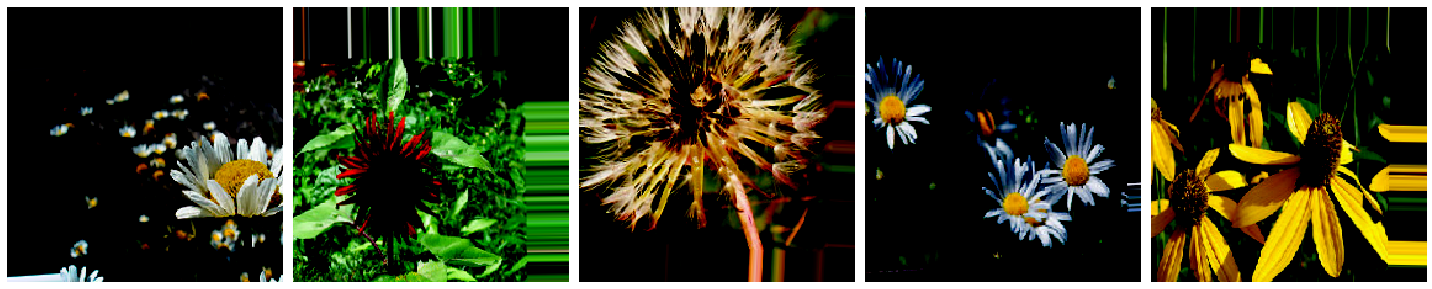

In [4]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])

In [19]:
from keras.models import load_model
from sklearn.datasets import load_files   
from keras.utils import np_utils
from glob import glob
from keras import applications
from keras.preprocessing.image import ImageDataGenerator 
from keras import optimizers
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization, Concatenate, GlobalMaxPooling2D
from keras.callbacks import ReduceLROnPlateau, LambdaCallback, ModelCheckpoint, LearningRateScheduler

# 訓練用的超參數
batch_size = 32
epochs = 30
data_augmentation = True
num_classes = 5
input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)

def create_resnet_50_model(num_classes=5, input_shape=(224, 224, 3)):

    model = applications.resnet_v2.ResNet50V2(include_top=False, pooling='avg', weights='imagenet', input_shape=input_shape)
    
    # model.summary()
    # model.trainable = False

    return model


# 架構主要 model
model_name = 'resnet50'

main_model = Sequential()

if model_name == 'resnet50':
  base_model = create_resnet_50_model(num_classes, input_shape)
  main_model.add(base_model)

  # 想辦法讓訓練不要這麼飄
  # main_model.add(BatchNormalization())
  # main_model.add(Dense(2048, activation='relu'))
  # main_model.add(BatchNormalization())
  # main_model.add(Dense(1024, activation='relu'))
  # main_model.add(BatchNormalization())
  main_model.add(Dense(num_classes, activation='softmax'))

# 因為是遷移學習，本來就有訓練了，縮小 learning rate，才不會讓訓練好的成果跑掉
# opt = optimizers.SGD(lr=1e-4, momentum=0.9)
opt = optimizers.Adam(lr=1e-4)
# opt=optimizers.RMSprop(lr=1e-5)

main_model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# 檢查是否凍結 ALL
print("--檢查 ALL 是否凍結-----------------")
for layer in main_model.layers:
    print(layer.name, ' is trainable? ', layer.trainable)

main_model.summary()

model = main_model

--檢查 ALL 是否凍結-----------------
resnet50v2  is trainable?  True
dense_5  is trainable?  True
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2048)              23564800  
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 10245     
Total params: 23,575,045
Trainable params: 23,529,605
Non-trainable params: 45,440
_________________________________________________________________


In [20]:
# 訓練模型囉！
batch_size=512

# checkpoint 儲存最好的一個

# shutil.rmtree('best_loss', ignore_errors=True)
if not os.path.exists('best_loss'):
  os.makedirs('best_loss')

weight_path="./best_loss/epoch_{epoch:02d}_val_acc_{val_acc:.4f}_val_loss_{val_loss:.4f}.h5"
best_weight_path = "./best_weight.h5"

ck_epoch_weight = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                                          save_weights_only=True,
                                          save_best_only=True,
                                          mode='min')

ck_best_weight = ModelCheckpoint(best_weight_path, monitor='val_loss', verbose=1,
                                        save_weights_only=True,
                                        save_best_only=True,
                                        mode='min')

# 使用自動降低學習率 (當 validation loss 連續 5 次沒有下降時，自動降低學習率)
lr_reducer = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.8,
    patience=5,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=5,
    min_lr=1e-14)

# early = EarlyStopping(monitor="val_loss", 
#                       mode="min", 
#                       patience=10) # probably needs to be more patient, but kaggle time is limited

# 學習率動態調整。當跑到第幾個 epcoh 時，根據設定修改學習率。這邊的數值都是參考原 paper
def lr_schedule(epoch):
    lr = 1e-4
    if epoch > 500:
        lr = 1e-7
    elif epoch > 200:
        lr = 1e-6
    elif epoch > 100:
        lr = 1e-5
    print('Learning rate: ', lr)
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

# 設定 callbacks
callbacks = [ck_epoch_weight, ck_best_weight, lr_reducer]

epochs = 80

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size,
    callbacks=callbacks,
    workers=2
)

# 評估模型
# scores = model.evaluate(x_test, y_test, verbose=1)
# print('Test loss:', scores[0])
# print('Test accuracy:', scores[1])

Epoch 1/80
3/3 [==============================] - 41s 14s/step - loss: 1.6944 - acc: 0.2760 - val_loss: 1.2380 - val_acc: 0.5234

Epoch 00001: val_loss improved from inf to 1.23798, saving model to ./best_loss/epoch_01_val_acc_0.5234_val_loss_1.2380.h5

Epoch 00001: val_loss improved from inf to 1.23798, saving model to ./best_weight.h5
Epoch 2/80
3/3 [==============================] - 2s 716ms/step - loss: 1.0772 - acc: 0.6042 - val_loss: 0.8207 - val_acc: 0.7031

Epoch 00002: val_loss improved from 1.23798 to 0.82068, saving model to ./best_loss/epoch_02_val_acc_0.7031_val_loss_0.8207.h5

Epoch 00002: val_loss improved from 1.23798 to 0.82068, saving model to ./best_weight.h5
Epoch 3/80
3/3 [==============================] - 2s 657ms/step - loss: 0.7932 - acc: 0.7527 - val_loss: 0.6664 - val_acc: 0.7344

Epoch 00003: val_loss improved from 0.82068 to 0.66644, saving model to ./best_loss/epoch_03_val_acc_0.7344_val_loss_0.6664.h5

Epoch 00003: val_loss improved from 0.82068 to 0.66644

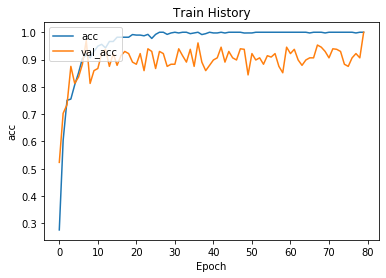

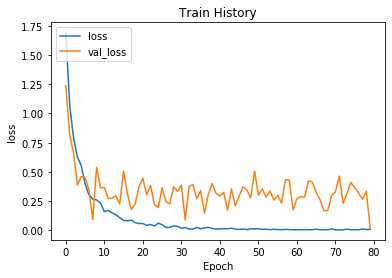

In [21]:
import matplotlib.pyplot as plt
def show_train_history(train,val):
    plt.plot(history.history[train])
    plt.plot(history.history[val])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend([train, val], loc='upper left')
    plt.show()
    
show_train_history('acc','val_acc')

show_train_history('loss','val_loss')

In [22]:
# Set the path of the input folder 
# pred_path = "../input/ml100-03-final/image_data/test/"
pred_path = "./image_data/"

#Test DataSet Generator with Augmentation
print("\nTest Data Set")
pred_generator = ImageDataGenerator(**datagen) # Generator for our validation data

pred_flow = train_image_generator.flow_from_directory(
    batch_size=128,
    directory=pred_path,
    shuffle=False,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    classes=['test'],
    class_mode=None)

print("pred_flow.samples:", pred_flow.samples)
print("pred_flow.batch_size:", pred_flow.batch_size)


Test Data Set
Found 2000 images belonging to 1 classes.
pred_flow.samples: 2000
pred_flow.batch_size: 128


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


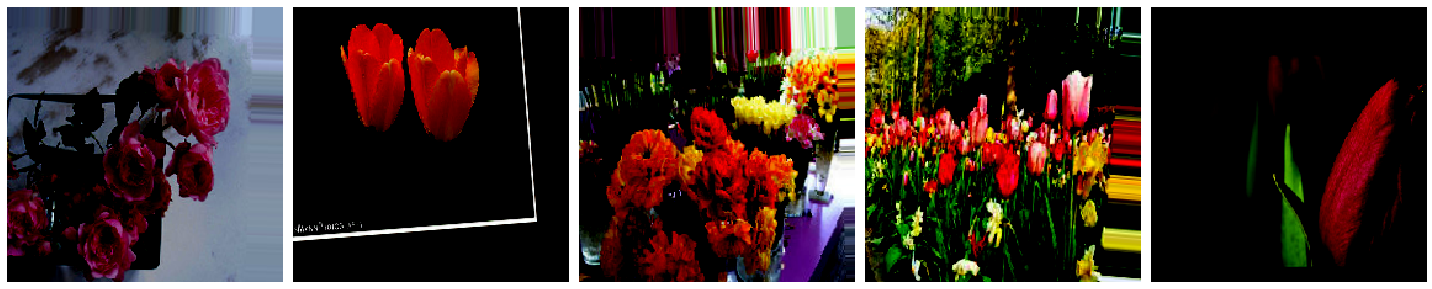

In [23]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

sample_training_images = next(pred_flow)
plotImages(sample_training_images[:5])

In [24]:
# from keras.models import load_model, load_weights
# w_path = './best_loss/epoch_48_val_acc_0.9394_val_loss_0.1512.h5'
# model.load_weights(w_path)
model.load_weights(best_weight_path)

# 預測結果
predictions = model.predict_generator(pred_flow, verbose=1)
predictions = np.argmax(predictions, axis=-1) #multiple categories

16/16 [==============================] - 25s 2s/step


In [0]:
# 輸出 CSV
import time
timestr = time.strftime("%Y%m%d_%H%M%S")
output_path = './best_{}.csv'.format(timestr)

get_file_name = lambda x: os.path.splitext(os.path.basename(x))[0]

pd_output_result = pd.DataFrame({'id': map(get_file_name, pred_flow.filenames), 'flower_class': predictions})
pd_output_result.to_csv(output_path, encoding='utf-8', index=False)
pd_output_result.head()

# 儲存最好的結果 load model and weights
model.save('best_model.h5')